### Disclaimer I am not a trained healthcare nor forecasting professional and this is a hobby prediction. 
### Observation date needs to be updated as new data arrives. 
#### This is a forked version of work done by attribution Daner Ferhadi Dferhadi with notice changed countries. Please see original code here: 
[https://www.kaggle.com/dferhadi/covid-19-predictions-growth-factor-and-calculus](https://www.kaggle.com/dferhadi/covid-19-predictions-growth-factor-and-calculus)

Original authors Disclaimer: This notebook demonstrates a very simple mathematical model, a differential equation called the logistic equation which is a special case of the Bernoulli equation. The purpose of this notebook was to illustrate mathematical modeling with simple ordinary differential equations to my introductory mathematical modeling class. I am not a health expert, this notebook should not be taken too seriously.

https://www.apache.org/licenses/LICENSE-2.0

# **The Math: Exponential vs Logistic**

### The spread of infectious disease can be modeled using a logistic curve rather than an exponential curve. The growth starts exponentially, but must slow down after some point called the **inflection point**. The inflection point is essentially the midpoint of the spread. We will model the number of confirmed cases using a logistic curve. Let's look at the equation for such a curve, the differential equation for which this curve is a solution, and the graph of the curve.

## Logistic Curve Graph

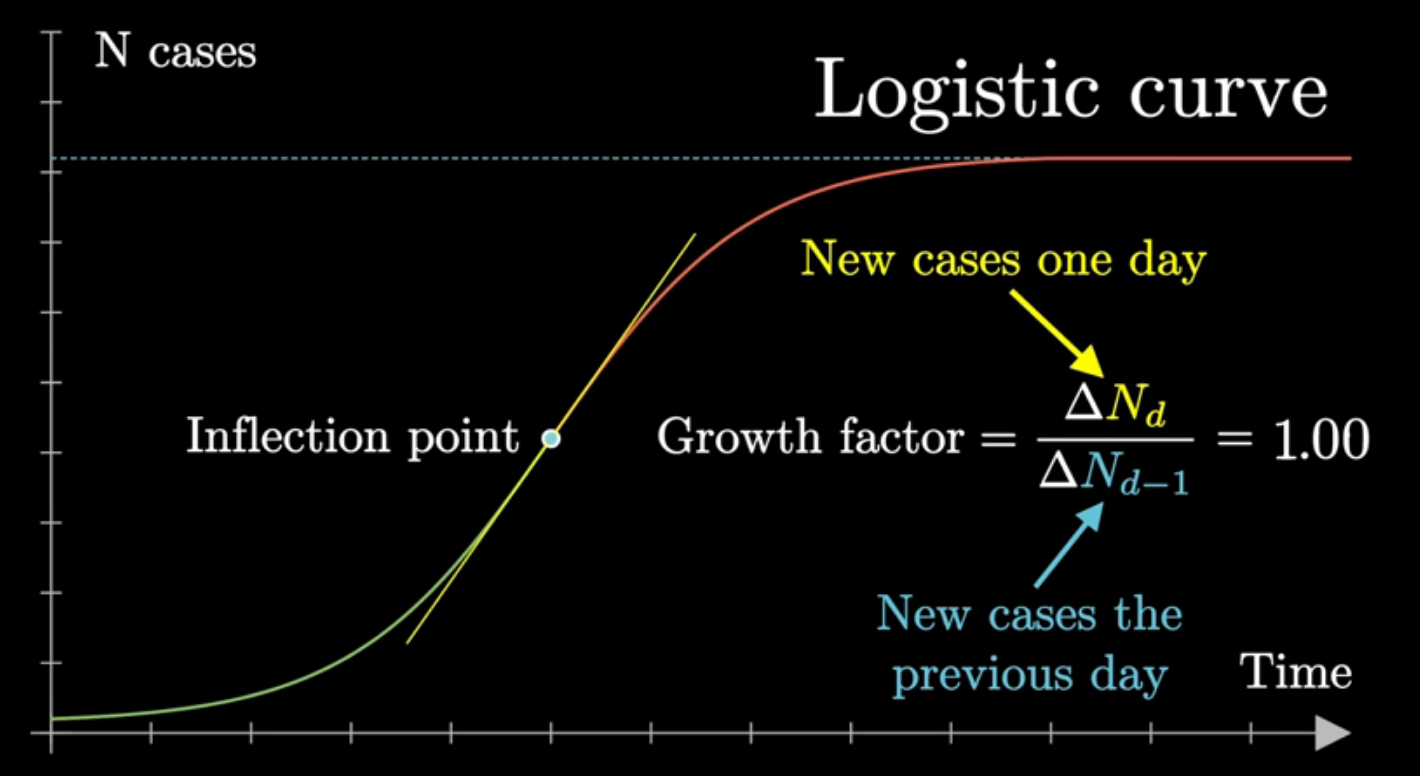

## Logistic Function

### A **logistic function** or **logistic curve** is an equation of the form: 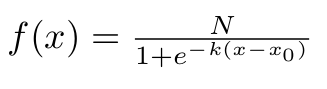
### where

### * x_0 = the inflection point,
### * N = the curve's maximum value, and
### * k = growth rate or steepness of the curve.

For reference: https://en.wikipedia.org/wiki/Logistic_function.
### Actually, the logistic function is just a solution for the following first-order, non-linear ordinary differential equation called the Logistic Differential Equation where f(x_0) = N/2: 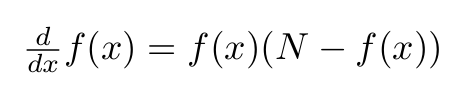

### From the differential equation, stability of solutions and equilibria can be explored. However, this may not be directly helpful in predicting confirmed cases, so let's keep things simple for now and just look at the growth metrics.


This part has been changed.

# **The Analysis**

### Now that we have seen the math, let's explore the following growth metrics for the confirmed cases for each country:
### * Growth Factor
### * Growth Ratio
### * Growth Rate
### * 2nd Derivative

### The **growth factor** on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.

### The **growth ratio** on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.

### The **growth rate** is simply the first derivative.

### We will use these growth metrics to gain insight into which countries may have already hit their inflection points. For example, if a country's growth factor has stabilized around 1.0 then this can be a sign that that country has reached it's inflection point. We will then use curve fitting to fit a logistic curve (similar to the one above) to the number of confirmed cases for each country. This may help us predict if a country has hit their inflection point, and therefore when they will reach a possible maximum number of confirmed cases.

### **Interestingly, the growth factor just tells us the curvature (from Calculus!) of the data.** If we take our data and take the 2nd derivative, basically all it is telling us is whether the cases are growing at an accelerating or decelerating rate. From calculus you may remember we use the 2nd derivative test to test for concavity and find saddle points. The inflection point is where the curve changes concavity. We can look at these growth metrics

### The bigger picture will be to correlate this with preventative efforts such as quarentines, closing of schools, etc. It will also be interesting to see growth factor as a feature in a ML model.

## Import Data

In [ ]:
# Input data files are available in the "../input/" directory.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



In [ ]:
global_data = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
global_data.tail()



* Define Active Cases as Confirmed minus Recovered minus Deaths.
* Drop SNo, Province/State, and Last Update.
* Plot Active, Confirmed, and Recovered Cases, Deaths, Growth Factor, 2nd_Derivative, and Growth Ratio



In [ ]:
#We will use it to smooth the data for growth factor. Special thanks to Dan Pearson fo rthe smoother() function below.
def smoother(inputdata,w,imax):
    data = 1.0*inputdata
    data = data.replace(np.nan,1)
    data = data.replace(np.inf,1)
    #print(data)
    smoothed = 1.0*data
    normalization = 1
    for i in range(-imax,imax+1):
        if i==0:
            continue
        smoothed += (w**abs(i))*data.shift(i,axis=0)
        normalization += w**abs(i)
    smoothed /= normalization
    return smoothed
# function to compute growth factor
def growth_factor(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    confirmed_iminus2 = confirmed.shift(2, axis=0)
    return (confirmed-confirmed_iminus1)/(confirmed_iminus1-confirmed_iminus2)
#function to compute growth ratio
def growth_ratio(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return (confirmed/confirmed_iminus1)

# We don't need a function for growth rate since we can use the np.gradient() function.

# This is a function which plots (for in input country) the active, confirmed, and recovered cases, deaths, and the growth factor.
def plot_country_active_confirmed_recovered_growth_metrics(country):
    
    # Plots Active, Confirmed, and Recovered Cases. Also plots deaths.
    country_data = global_data[global_data['Country/Region']==country]
    table = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
    table['ActiveCases'] = table['Confirmed'] - table['Recovered'] - table['Deaths']
    table2 = pd.pivot_table(table, values=['ActiveCases','Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
    table3 = table2.drop(['Deaths'], axis=1)
   
    # Growth Factor
    w = 0.5
    table2['GrowthFactor'] = growth_factor(table2['Confirmed'])
    table2['GrowthFactor'] = smoother(table2['GrowthFactor'],w,5)

    # 2nd Derivative
    table2['2nd_Derivative'] = np.gradient(np.gradient(table2['Confirmed'])) #2nd derivative
    table2['2nd_Derivative'] = smoother(table2['2nd_Derivative'],w,7)


    #Plot confirmed[i]/confirmed[i-1], this is called the growth ratio
    table2['GrowthRatio'] = growth_ratio(table2['Confirmed'])
    table2['GrowthRatio'] = smoother(table2['GrowthRatio'],w,5)
    
    #Plot the growth rate, we will define this as k in the logistic function presented at the beginning of this notebook.
    table2['GrowthRate']=np.gradient(np.log(table2['Confirmed']))
    table2['GrowthRate'] = smoother(table2['GrowthRate'],0.5,3)
    
    # horizontal line at growth rate 1.0 for reference
    x_coordinates = [1, 180]
    y_coordinates = [1, 1]
    #plots
    table2['Deaths'].plot(title='Deaths')
    plt.rcParams["figure.figsize"] = (12,3)
    plt.show()
    table3.plot() 
    plt.show()
    table2['GrowthFactor'].plot(title='Growth Factor')
    plt.plot(x_coordinates, y_coordinates) 
    plt.show()
    table2['2nd_Derivative'].plot(title='2nd_Derivative')
    plt.show()
    table2['GrowthRatio'].plot(title='Growth Ratio')
    plt.plot(x_coordinates, y_coordinates)
    plt.show()
    table2['GrowthRate'].plot(title='Growth Rate')
    plt.show()

    
   # import plotly.express as px
   # table3 = table3.melt(id_vars="ObservationDate", value_vars=['ActiveCases','Confirmed','Recovered'],
   #              var_name='case', value_name='count')
   # table3.reindex()
   # fig = px.area(table3, x="ObservationDate", y="count", color='case',
   #              title='Confirmed Cases', color_discrete_sequence = ['cyan', 'red', 'orange'])
   # fig.show()

    return 


## Mexico
This part has been changed

In [ ]:
plot_country_active_confirmed_recovered_growth_metrics('Mexico')

We see a dramatic decrease in growth ratio and growth factor for china, until it stabilizes around 1.0.

What's also interesting is that we see that China's confirmed curve and recovered curve already resemble a logistic curve. We should be able to estimate an inflection point for China, and as you will see South Korea. We can maybe then use these to build a model to predict countries like Italy, Germany, Spain, and the United States. Future versions of this kernel will explore this.

## Sweden
This part has been changed.

In [ ]:
plot_country_active_confirmed_recovered_growth_metrics('Sweden')

Let's now compare China with the rest of the world.

## Logistic Curve Fitting

We are going to use scipy.optimize.curve_fit to fit a logistic curve to the number of confirmed cases in US.

In [ ]:
from scipy.optimize import curve_fit


In [ ]:
# We want number of confirmed for each date for each country
#country_data = global_data[global_data['Country/Region']=='Mainland China']
country_data = ""
global_data2 = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
#global_data2 = pd.read_csv("../input/corona-virus-report/covid_19_clean_complete.csv")
country_data = global_data2[global_data2['Country/Region']=='Sweden']
#country_data = country_data[country_data['ObservationDate']<"06/15/2020"]
#country_data = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
country_data.tail(10)
#country_data = pd.pivot_table(country_data, values=['Confirmed', 'Recovered','Deaths'], index=['Date'], aggfunc=np.sum)
country_data = pd.pivot_table(country_data, values=['Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
#country_data = country_data.append({'ObservationDate':'05/26/2020','Confirmed' : '10.0' , 'Deaths' : "22.0", 'Recovered': '10'},ignore_index=True)
country_data.tail(10)
#foo.tail()

In [ ]:
#country_data['GrowthFactor'] = growth_factor(country_data['Confirmed'])
import math
# we will want x_data to be the number of days since first confirmed and the y_data to be the confirmed data. This will be the data we use to fit a logistic curve
x_data = range(len(country_data.index))
y_data = country_data['Confirmed']

def log_curve(x, k, x_0, ymax):
    return ymax / (1.0 + np.exp(-k*(x-x_0)))

# Fit the curve
popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf), maxfev=50000)
estimated_k, estimated_x_0, ymax= popt

n_order = 3
#X_train = np.vander(x_train, n_order + 1, increasing=True)
Y_test = np.vander(y_data, n_order + 1, increasing=True)
Y_test

# Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0
y_fitted = log_curve(range(0,250), k*1.0, x_0, ymax)
print(k, x_0, ymax)
#print(y_fitted)
y_data.tail()

## Plot everything for illustration

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,250), y_fitted, '--', label='fitted')
#ax.plot(range(0,), y_test, '--', label='fitted')
ax.plot(x_data, y_data, 'o', label='Confirmed Data')
